# Telecom Churn Prediction

In [28]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import IterativeImputer
from datetime import date
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
import xgboost as xgb
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

warnings.filterwarnings('ignore')


pd.options.display.max_columns = 300

In [29]:
df = pd.read_csv("train.csv")

In [30]:
df.head(5)

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [31]:
df.isna().sum()

id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64

In [32]:
df.shape

(69999, 172)

In [33]:
def columns_with_missing_data_more_than_threshold(df,threshold):
    rows=df.shape[0]
    res_cols=[]
    nan_values = df.isna()
    for col in nan_values:
        nan_row_count=df[col].isna().sum()
        if (nan_row_count/rows)>threshold:
            res_cols.append(col)
          #  res_cols.append((col,nan_row_count/rows))
    return res_cols

In [34]:
df.drop(columns_with_missing_data_more_than_threshold(df,0.7),inplace=True,axis=1)

df['churn_probability'].value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

### Assumptions

#### 1. Missing values for most columns are between 2-5% and they constitute about 4% on churn out of 11%. Most of them are about options/plans users didn't pick so filling them with default 0.

#### 2. High value customer have summed up arpu of 3 months greater than 60 th percentile

In [35]:
df=df.fillna(0)

In [36]:
df.shape

(69999, 142)

In [37]:
len(columns_with_missing_data_more_than_threshold(df,0.02))

0

In [38]:
df.describe()


id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69999.0         69999.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69999.0  69999.000000  69999.000000  69999.000000  69999.000000   
mean              0.0    283.134365    278.185912    278.858826    127.887939   
std               0.0    334.213918    344.366927    351.924315    295.115497   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      5.430000   
50%               0.0    197.484000    191.588000    192.234000     30.830000   
75%               0.0    370.791000    365.369500    369.909000    113.100000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     128.754731    125.943607    191.010582    189.585401    186.146273   
std      306.326345    304.990552    312.900706    318.492632    318.453812   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.910000      4.110000     28.790000     26.690000     23.780000   
50%       29.160000     27.840000     89.810000     85.590000     83.010000   
75%      108.940000    106.280000    223.540000    218.350000    216.410000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count   69999.000000   69999.000000   69999.000000   69999.000000   
mean        9.379276       6.745305       6.634328      13.625476   
std        56.260778      54.892940      51.999899      72.055036   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      2850.980000    4155.830000    4169.810000    3775.110000   

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   69999.000000   69999.000000      69999.000000      69999.000000   
mean        9.464386       9.254848         45.050076         44.394344   
std        57.409013      62.923987        148.238746        151.998993   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.010000          1.010000   
50%         0.000000       0.000000         10.660000         10.430000   
75%         0.000000       0.000000         38.680000         37.780000   
max      2812.040000    5337.040000       6431.330000       7400.660000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count      69999.000000      69999.000000      69999.000000      69999.000000   
mean          43.269280         89.551272         87.313796         86.301054   
std          149.944829        159.846546        151.875981        150.286404   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.760000          7.290000          7.530000          6.440000   
50%           10.060000         37.680000         37.010000         35.940000   
75%           37.260000        105.685000        103.330000        103.110000   
max        10752.560000       4696

In [39]:
df['churn_probability'].value_counts()

# Churn cases are very less, near to 11.3%

0    62867
1     7132
Name: churn_probability, dtype: int64

In [40]:
drop_cols=['id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7',
           'std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','last_date_of_month_6',
          'last_date_of_month_7','last_date_of_month_8','circle_id','id']

df.drop(drop_cols,inplace=True,axis=1)

In [41]:
df_churn=df[df['churn_probability']==1]

In [42]:
df_churn.describe()

arpu_6       arpu_7       arpu_8  onnet_mou_6  onnet_mou_7  \
count   7132.000000  7132.000000  7132.000000  7132.000000  7132.000000   
mean     308.289067   219.081400   114.226380   166.784865   115.935868   
std      385.723588   321.495315   245.585045   379.161173   324.498571   
min     -209.465000  -158.963000  -155.236000     0.000000     0.000000   
25%       96.093500    14.745250     0.000000     0.960000     0.000000   
50%      210.676500   118.348000     9.969500    30.545000     9.240000   
75%      409.335750   289.543500   137.013250   151.932500    80.600000   
max    11505.508000  6876.324000  5731.327000  7011.110000  8157.780000   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  7132.000000   7132.000000   7132.000000   7132.000000    7132.000000   
mean     49.731139    208.525578    146.238458     62.277647      16.007982   
std     205.869032    383.065613    327.557099    186.283286      92.650506   
min       0.000000      0.000000      0.000000      0.000000       0.000000   
25%       0.000000     10.725000      0.000000      0.000000       0.000000   
50%       0.000000     78.620000     31.535000      0.000000       0.000000   
75%      16.317500    232.562500    139.832500     39.292500       1.010000   
max    5193.660000   8362.360000   5887.140000   4167.740000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count    7132.000000    7132.000000    7132.000000    7132.000000   
mean       15.519393      14.477426      24.591959      21.067705   
std       103.923504      89.055082     109.668718      90.710144   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.530000       2.115000       3.152500       3.587500   
max      4155.830000    2898.340000    3161.790000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count    7132.000000       7132.000000       7132.000000       7132.000000   
mean       20.169801         27.382006         17.480652          7.165370   
std       101.143511        128.950619         78.467216         57.092275   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          0.000000          0.000000          0.000000   
50%         0.000000          3.185000          0.260000          0.000000   
75%         4.582500         18.917500         10.600000          0.480000   
max      5337.040000       4071.280000       2406.430000       3418.230000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count       7132.000000       7132.000000       7132.000000       7132.000000   
mean          53.537061         36.110890         14.330600          1.660059   
std          118.064034         99.470693         52.034069          7.662412   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%           13.440000          3.450000          0.000000          0.000000   
75%           54.090000         32.955000          4.060000          0.000000   
max         3285.360000       2780.460000       1297.510000        175.560000   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count       7132.000000       7132.000000       7132.000000       7132.000000   
mean           1.291847          0.656748          1.072225          1.327782   
std            7.027689          4.841696          6.160611         13.149469   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%

### Derived Columns 


In [43]:
df["date_of_last_rech_8"] = pd.to_datetime(df['date_of_last_rech_8'])
df["date_of_last_rech_7"] = pd.to_datetime(df['date_of_last_rech_7'])
df["date_of_last_rech_6"] = pd.to_datetime(df['date_of_last_rech_6'])

In [44]:
df['rchrge2_days']=(df['date_of_last_rech_8'] - df['date_of_last_rech_7']).dt.days
df['rchrge1_days']=(df['date_of_last_rech_7'] - df['date_of_last_rech_6']).dt.days

In [45]:
df.drop(['date_of_last_rech_8','date_of_last_rech_7','date_of_last_rech_6'], inplace=True, axis=1)

In [46]:
len(df.describe(exclude = ['object']).columns)

127

## High Value Customer Churn Analysis

In [47]:
hvc_df = df.copy()
hvc_df = hvc_df.fillna(0)

In [48]:
hvc_df['arpu'] = hvc_df['arpu_6']+hvc_df['arpu_7']+hvc_df['arpu_8']

In [49]:
limit = hvc_df['arpu'].quantile(0.6)
hvc_df = hvc_df[hvc_df['arpu']>limit]

In [50]:
hvc_df_corr = hvc_df[hvc_df['churn_probability']==1]
len(hvc_df_corr)
hvc_df.head(2)

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
11  292.724  228.753  418.233       135.54        63.61       177.36   
12  439.919  397.946  392.024       244.46       108.31        42.98   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
11         46.39         65.48         92.81            0.0            0.0   
12        571.98        727.91        644.43            0.0            0.0   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
11            0.0            0.0            0.0            0.0   
12            0.0            0.0            0.0            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
11             86.39             27.59             82.33             43.28   
12              0.00              7.86              3.98             44.01   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
11             29.49             83.54              0.58              0.36   
12             13.93             51.24              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
11               0.0              2.53               0.0               0.0   
12               0.0              0.00               0.0               0.0   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
11        130.26         57.46        165.88             49.14   
12         44.01         21.79         55.23            244.46   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
11             36.01             95.03              0.00             35.61   
12            100.44             38.99            527.96            713.98   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
11              9.26               0.0               0.0               0.0   
12            593.18               0.0               0.0               0.0   

    std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
11         49.14         71.63        104.29           0.0           0.0   
12        772.43        814.43        632.18           0.0           0.0   

    isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
11           0.0          2.53           0.0          0.35          0.0   
12           0.0          0.00           0.0          0.00          0.0   

    og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
11          0.0          0.0          181.94          129.09          270.53   
12          0.0          0.0          816.44          836.23          687.41   

    loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
11             66.34             62.03            115.13             60.46   
12              0.00              0.53              1.06             26.93   

    loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
11             45.23             61.26              0.38               0.0   
12             25.68             23.46              0.00               0.0   

    loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
11              0.41        127.19        107.26        176.81   
12              0.00         26.93         26.21         24.53   

    std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  std_ic_t2m_mou_6  \
11              6.73             44.76             86.19              0.00   
12              0.23              0.00              0.00              7.33   

    std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2f_mou_6  std_ic_t2f_mou_7  \
11              2.65             18.96               0.0              0.00   
12              8.64              2.46               0.0              0.48   

    std_ic_t2f_mou_8  std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  \
11               0.0          6.73         47.41        105.16   
12           

<AxesSubplot:xlabel='churn_probability', ylabel='arpu'>

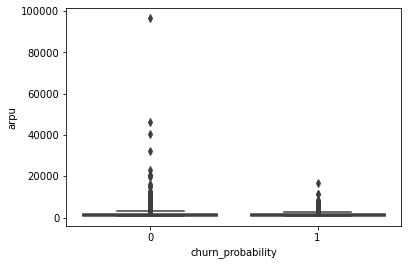

In [51]:
sns.boxplot(x="churn_probability", y="arpu", data=hvc_df)

In [52]:
hvc_df.groupby(by=['churn_probability']).mean()

arpu_6      arpu_7      arpu_8  onnet_mou_6  \
churn_probability                                                    
0                  490.681807  510.959220  520.941924    235.68780   
1                  646.398712  537.795529  289.464999    392.63841   

                   onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
churn_probability                                                         
0                   256.180713   255.655767    344.524672    364.189681   
1                   321.986861   145.295899    471.947302    386.176554   

                   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
churn_probability                                                              
0                    364.158543      14.212041      10.423870      10.200683   
1                    168.809122      28.315431      30.694834      30.862692   

                   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
churn_probability                                                
0                      23.311140      15.937731      15.912002   
1                      51.961616      48.751705      50.277864   

                   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
churn_probability                                                         
0                         82.871440         85.632557         84.108846   
1                         58.154485         44.119496         19.940457   

                   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
churn_probability                                                         
0                        160.242246        163.115321        162.566973   
1                        108.365821         88.467199         36.780915   

                   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
churn_probability                                                         
0                          6.332863          6.543573          6.284959   
1                          3.506767          3.150489          1.766258   

                   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
churn_probability                                                         
0                          1.432757          1.739946          1.869534   
1                          1.578841          2.116159          1.072282   

                   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
churn_probability                                                               
0                    249.455115    255.300372    252.969656        143.617534   
1                    170.034122    135.743825     58.491232        312.554298   

                   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  \
churn_probability                                                         
0                        164.267953        165.522937        156.095392   
1                        256.632053        102.981445        320.128311   

                   std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
churn_probability                                                         
0                        176.905053        177.072307          1.812487   
1                        258.898633         98.638165          1.231237   

                   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  \
churn_probability                                                     
0                          1.787613          1.731899    301.529343   
1                          1.200780          0.418332    633.918477   

                   std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
churn_probability                                                           
0                    342.964675    344.331104      1.685259      1.740855   
1                    516.735847    202.040203      4.384558      2.895255   

                   isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
churn_probability                                    

### Observations

#### 1. arpu of customer which are going to churn follows monotonous decreasing trend.

#### 2.  [onnet_mou, offnet_mou, loc_og_t2t_mou, loc_og_t2m_mou, loc_og_t2f_mou , loc_og_mou, std_og_t2t_mou, std_og_t2m_mou,  std_og_mou, isd_og_mou,spl_og_mou, total_og_mou, loc_ic_t2t_mou, loc_ic_t2m_mou ..... etc] also follows same trend as arpu .

#### 3. aon of churning customer is lesser than non churn. 

#### Inference: Data indicates customer which going to churn have reduced activity and spends for the service, if there such pattern then the customer with low aon are more likely churn



### Correlation Analysis

In [53]:

sns.clustermap(df.corr(), annot=True,cmap="RdBu",figsize=(200,200))

In [152]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset


In [153]:
df_new = df.copy()

In [154]:
correlation(df_new,0.85)
df_new

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0       31.277   87.009    7.527        48.58       124.38         1.29   
1        0.000  122.787   42.953         0.00         0.00         0.00   
2       60.806  103.176    0.000         0.53        15.93         0.00   
3      156.362  205.260  111.095         7.26        16.01         0.00   
4      240.708  128.191  101.565        21.28         4.83         6.13   
...        ...      ...      ...          ...          ...          ...   
69994   15.760  410.924  329.136         0.00         7.36        10.93   
69995  160.083  289.129  265.772       116.54       196.46       232.63   
69996  372.088  258.374  279.782        77.13        68.44        78.44   
69997  238.575  245.414  145.062        14.01         7.64         6.71   
69998  168.269   42.815  167.961         0.00         0.00         0.00   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0             32.24         96.68          2.33           0.00            0.0   
1              0.00         25.99         30.89           0.00            0.0   
2             53.99         82.05          0.00           0.00            0.0   
3             68.76         78.48         50.23           0.00            0.0   
4             56.99         38.11          9.63          53.64            0.0   
...             ...           ...           ...            ...            ...   
69994          0.00        488.46        381.64          14.96            0.0   
69995         49.53         96.28         48.06           0.00            0.0   
69996        335.54        227.94        263.84           0.00            0.0   
69997         30.34         16.68         12.56          25.06            0.0   
69998          0.00          0.00          0.00           0.00            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0                0.0           0.00            0.0           0.00   
1                0.0           0.00            0.0           0.00   
2                0.0           0.00            0.0           0.00   
3                0.0           0.00            0.0           1.63   
4                0.0          15.73            0.0           0.00   
...              ...            ...            ...            ...   
69994            0.0           0.00            0.0           0.00   
69995            0.0           0.00            0.0           0.00   
69996            0.0           0.00            0.0           0.00   
69997            0.0           4.58            0.0           0.00   
69998            0.0           0.00            0.0           0.00   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0                  2.23              0.00              0.28              5.29   
1                  0.00              0.00              0.00              0.00   
2                  0.53             12.98              0.00             24.11   
3                  6.99              3.94              0.00             37.91   
4                 10.16              4.83              6.13             36.74   
...                 ...               ...               ...               ...   
69994              0.00              2.44              7.19              0.00   
69995              7.18             30.11              9.06             37.53   
69996             77.13             44.28             78.44            143.19   
69997             10.88              7.64              6.71              4.44   
69998              0.00              0.00              0.00              0.00   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0                 16.04              2.33              0.00              0.00   
1                  0.00              0.00              0.00              0.00   
2                  0.00              0.00              0.00              0.00   
3       

## Feature Selection

### Random Forest Classifier

In [155]:
feature_df = df_new.copy()
y=feature_df.pop('churn_probability')
X = feature_df
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [171]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

count    108.000000
mean       0.009259
std        0.013877
min        0.000096
25%        0.002478
50%        0.005964
75%        0.009792
max        0.098814
dtype: float64

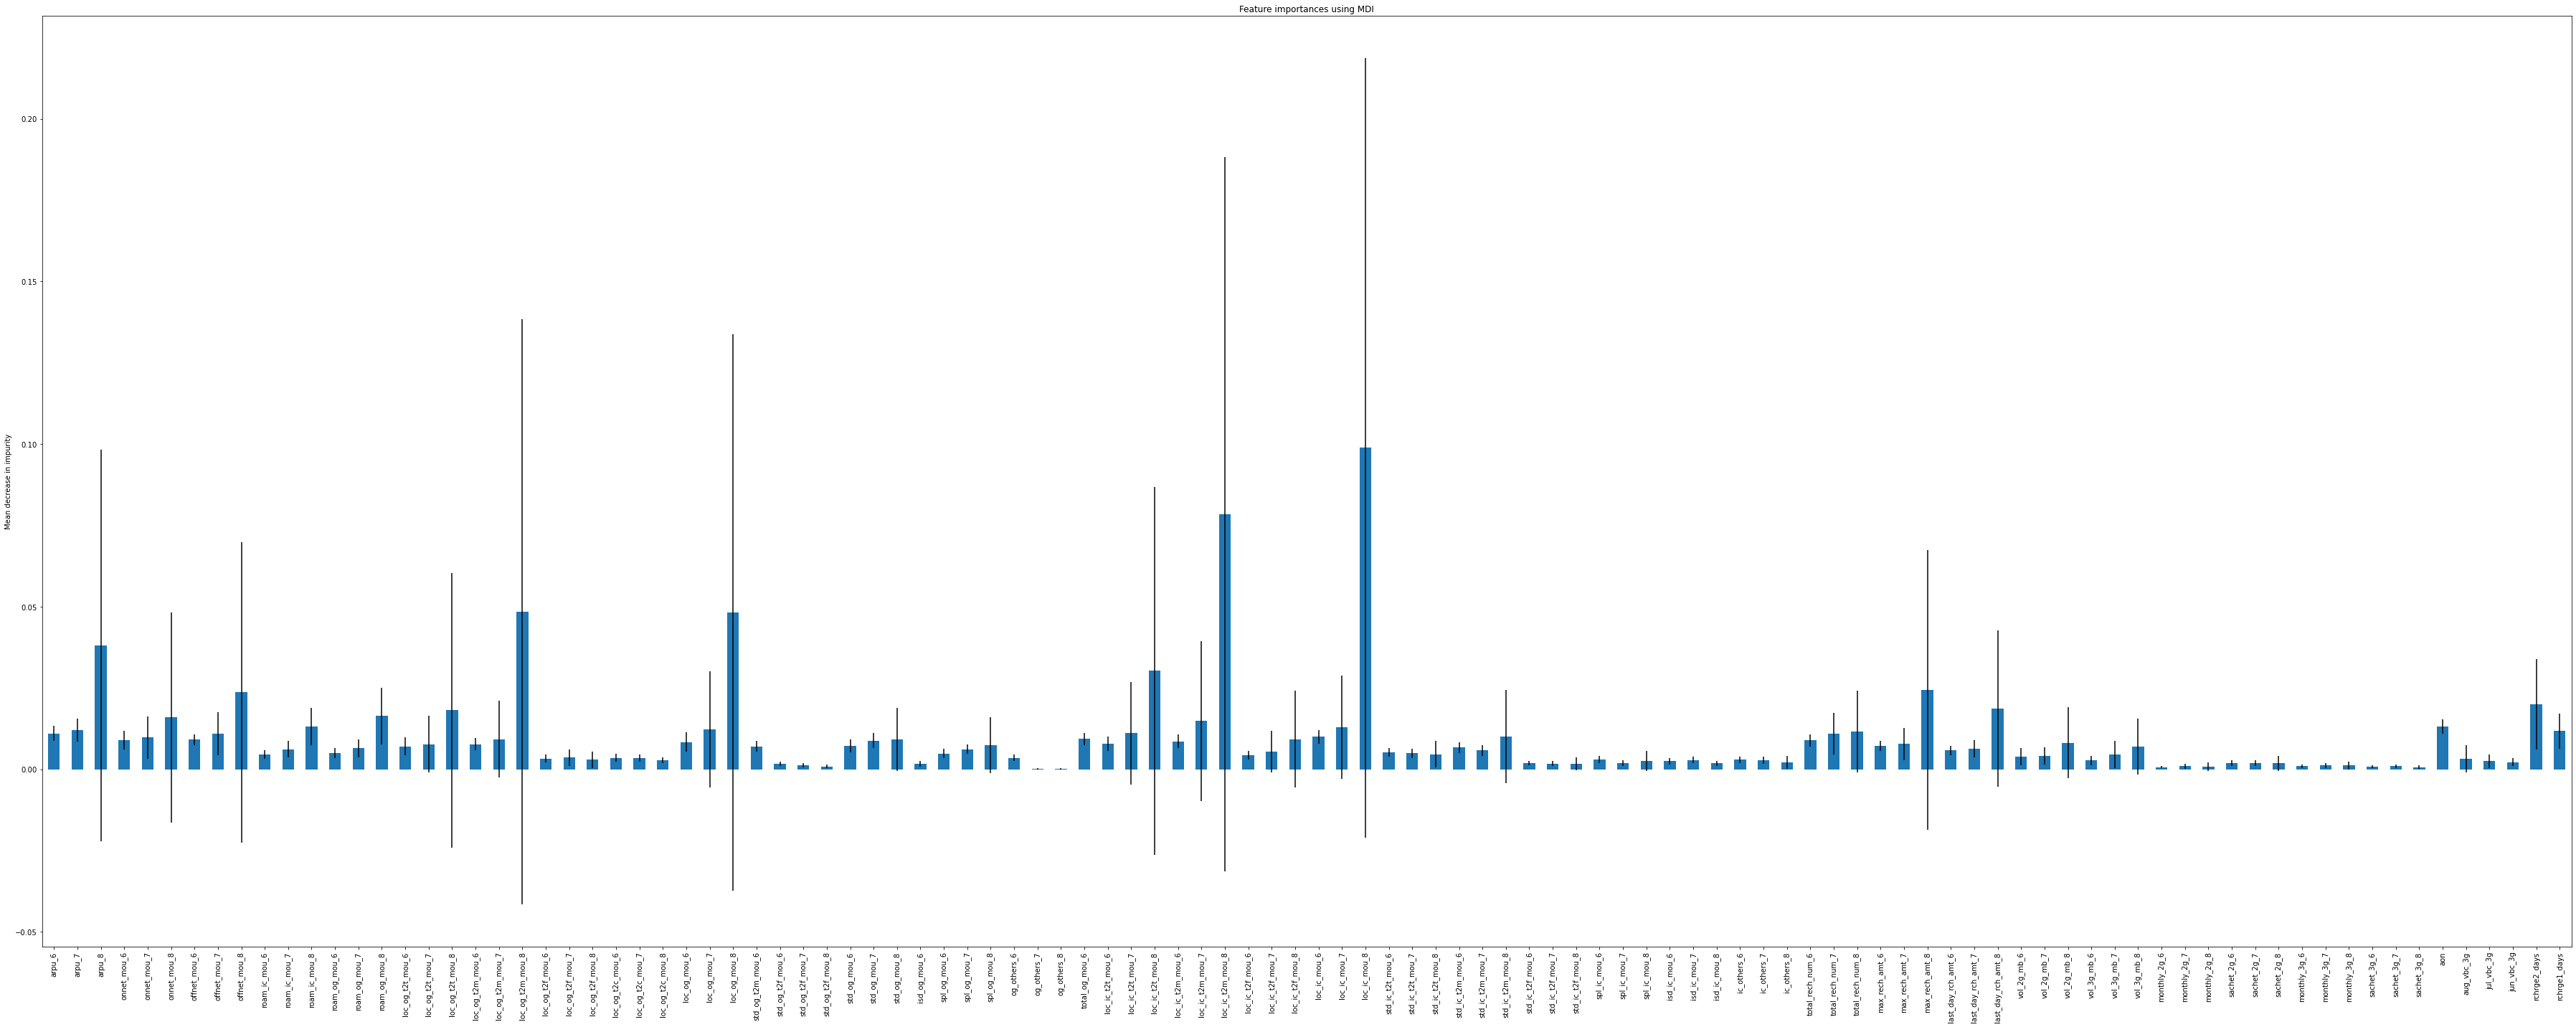

In [172]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(50,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
forest_importances.describe()

In [173]:
feature_importance_df = pd.DataFrame(forest_importances)
feature_importance_df.reset_index(inplace=True)
feature_importance_df.columns=['features',"importance"]
len(feature_importance_df[feature_importance_df['importance']>0.01])


26

In [175]:
feature_importance_df = feature_importance_df[feature_importance_df['importance']>0.01]
imp_cols = list(feature_importance_df.features)
imp_cols.append('churn_probability')
imp_cols

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_8',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_8',
 'roam_og_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_t2m_mou_8',
 'total_rech_num_7',
 'total_rech_num_8',
 'max_rech_amt_8',
 'last_day_rch_amt_8',
 'aon',
 'rchrge2_days',
 'rchrge1_days',
 'churn_probability']

In [176]:
data = df_new[imp_cols].dropna()

In [177]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_8  offnet_mou_7  offnet_mou_8  \
0   31.277   87.009    7.527         1.29         96.68          2.33   
1    0.000  122.787   42.953         0.00         25.99         30.89   
2   60.806  103.176    0.000         0.00         82.05          0.00   
3  156.362  205.260  111.095         0.00         78.48         50.23   
4  240.708  128.191  101.565         6.13         38.11          9.63   

   roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
0            0.0           0.00              0.28              2.33   
1            0.0           0.00              0.00              0.00   
2            0.0           0.00              0.00              0.00   
3            0.0           1.63              0.00             23.63   
4            0.0           0.00              6.13              4.61   

   loc_og_mou_7  loc_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0         16.04          2.61              3.68              7.79   
1          0.00          0.00             19.09             10.53   
2         12.98          0.00              6.16              6.49   
3         48.84         23.63              4.84             23.88   
4         25.94         15.76              1.39              2.66   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
0             21.08             16.91         24.76         24.71   
1             18.68             11.09         39.44         25.03   
2             25.18             23.51         31.34         30.01   
3             44.23             57.14         49.89         81.03   
4              4.33             19.49          9.36         28.31   

   std_ic_t2m_mou_8  total_rech_num_7  total_rech_num_8  max_rech_amt_8  \
0             14.96                 2                 2              10   
1              0.00                 4                 5              50   
2              6.38                 4                 2               0   
3              2.81                 4                 3              50   
4              0.00                10                 8              30   

   last_day_rch_amt_8   aon  rchrge2_days  rchrge1_days  churn_probability  
0                   0  1958            45            18                  0  
1                   0   710            47            28                  0  
2                   0   882            33            41                  0  
3                  50   982            35            36                  0  
4                  30   647            35            31                  0

## Data Split


In [178]:
y=data.pop('churn_probability')
X=data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)


## Data Scaling

In [179]:
scaler = StandardScaler()
X_train

arpu_6   arpu_7    arpu_8  onnet_mou_8  offnet_mou_7  offnet_mou_8  \
59805   20.000  457.270     0.000         0.00        132.28          0.00   
32717  157.847  177.925    76.996       190.18        145.68        138.56   
5964   309.004  468.304   412.625         8.51        215.51         36.94   
47623  154.108   60.291   265.921        49.81         40.49        239.84   
31881  228.004  222.476   180.528        19.28        154.64        103.03   
...        ...      ...       ...          ...           ...           ...   
14260   85.500   43.496   359.137         0.00         25.08        239.81   
63370  684.527  707.502  1228.014        49.59        376.96        940.98   
65615  171.411  186.559   150.126        27.11        109.19         66.51   
56088  374.245  307.547   281.955        15.18        122.68         85.13   
38408  535.840  937.906   875.300       262.49        552.16        463.21   

       roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
59805           0.00           0.00              0.00              0.00   
32717           0.00           0.00            182.84            138.48   
5964           12.29           0.00              3.11             25.59   
47623           0.00           0.00             49.81            237.13   
31881           0.00           0.00             19.28             41.36   
...              ...            ...               ...               ...   
14260           0.00           0.00              0.00             12.96   
63370          78.99         223.39             49.59            358.53   
65615           0.00           0.00             27.11             64.66   
56088           0.00           0.00             12.71             32.71   
38408           4.41          16.75            252.69            374.86   

       loc_og_mou_7  loc_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
59805        189.49          0.00              0.66              0.00   
32717        265.19        321.33             55.54            103.26   
5964         102.86         29.88             53.19             28.66   
47623         53.21        286.94              0.00             33.64   
31881         69.79         60.88             46.11             36.41   
...             ...           ...               ...               ...   
14260          0.00         12.96              0.00              5.21   
63370        319.23        423.53              9.39             21.96   
65615        182.21         93.63             69.24              6.01   
56088         31.98         50.18              2.29              6.38   
38408        964.74        698.34             78.59             62.38   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
59805             60.93              0.00         61.59          0.00   
32717            433.21            282.41        494.78        385.68   
5964              81.58             80.66        134.78        109.33   
47623             60.38            494.19         60.38        538.38   
31881            193.03            104.49        239.14        141.03   
...                 ...               ...           ...           ...   
14260              2.93             27.28          2.93         32.49   
63370            366.63            390.03        384.29        417.74   
65615             77.09             35.38        147.33         41.99   
56088              8.98             15.43         14.91         25.36   
38408            306.18            280.96        504.76        431.14   

       std_ic_t2m_mou_8  total_rech_num_7  total_rech_num_8  max_rech_amt_8  \
59805              0.00                 1                 2               0   
32717              3.64                 5                 4             130   
5964              58.86                 9                 6             198   
47623              0.00                 2                 8              50   
31881             92.

In [180]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df

arpu_6    arpu_7    arpu_8  onnet_mou_8  offnet_mou_7  offnet_mou_8  \
0     -0.768898  0.507190 -0.769612    -0.410012     -0.180234     -0.580777   
1     -0.365549 -0.285280 -0.557039     0.211406     -0.138229     -0.148591   
2      0.076747  0.538493  0.369580    -0.382206      0.080665     -0.465556   
3     -0.376489 -0.618994 -0.035447    -0.247257     -0.467966      0.167314   
4     -0.160264 -0.158894 -0.271203    -0.347014     -0.110143     -0.259413   
...         ...       ...       ...          ...           ...           ...   
55994 -0.577241 -0.666639  0.221908    -0.410012     -0.516271      0.167220   
55995  1.175553  1.217070  2.620739    -0.247976      0.586758      2.354256   
55996 -0.325859 -0.260786 -0.355138    -0.321430     -0.252613     -0.373324   
55997  0.267647  0.082443  0.008821    -0.360411     -0.210327     -0.315246   
55998  0.740485  1.870700  1.646952     0.447680      1.135953      0.864032   

       roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
0          -0.126411      -0.143331         -0.286321         -0.574511   
1          -0.126411      -0.143331          0.923971          0.349501   
2           0.106308      -0.143331         -0.265734         -0.403761   
3          -0.126411      -0.143331          0.043392          1.007745   
4          -0.126411      -0.143331         -0.158699         -0.298535   
...              ...            ...               ...               ...   
55994      -0.126411      -0.143331         -0.286321         -0.488035   
55995       1.369310       3.281644          0.041935          1.817790   
55996      -0.126411      -0.143331         -0.106869         -0.143065   
55997      -0.126411      -0.143331         -0.202188         -0.356252   
55998      -0.042905       0.113477          1.386336          1.926752   

       loc_og_mou_7  loc_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0          0.220581     -0.551481         -0.309467         -0.322314   
1          0.529849      0.782479          0.064114          0.420307   
2         -0.133340     -0.427438          0.048117         -0.116199   
3         -0.336182      0.639714         -0.313960         -0.080384   
4         -0.268445     -0.298745         -0.000078         -0.060462   
...             ...           ...               ...               ...   
55994     -0.553568     -0.497679         -0.313960         -0.284845   
55995      0.750625      1.206750         -0.250040         -0.164383   
55996      0.190839     -0.162788          0.157373         -0.279092   
55997     -0.422915     -0.343165         -0.298371         -0.276431   
55998      3.387814      2.347588          0.221021          0.126308   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
0             -0.253067         -0.631570     -0.391769     -0.645050   
1              2.019725          1.119593      1.323462      0.931767   
2             -0.126997         -0.131415     -0.101971     -0.198064   
3             -0.256425          2.432795     -0.396560      1.556067   
4              0.553411          0.016350      0.311246     -0.068462   
...                 ...               ...           ...           ...   
55994         -0.607160         -0.462413     -0.624035     -0.512218   
55995          1.613250          1.786922      0.885973      1.062841   
55996         -0.154409         -0.412186     -0.052278     -0.473378   
55997         -0.570225         -0.535892     -0.576600     -0.541368   
55998          1.244199          1.110602      1.362978      1.117626   

       std_ic_t2m_mou_8  total_rech_num_7  total_rech_num_8  max_rech_amt_8  \
0             -0.266435         -0.947629         -0.724537       -0.860033   
1             -0.217320         -0.382929         -0.447131        0.180931   
2              0.527776          0.181771         -0.169724        0.725436   
3             -0.266435         -0.806454          0.107683       -0.459663  

In [181]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled_df

arpu_6    arpu_7    arpu_8  onnet_mou_8  offnet_mou_7  offnet_mou_8  \
0     -0.725879  0.808836 -0.783831    -0.410012      1.990935     -0.575911   
1      1.433047  0.826856 -0.082563    -0.326266      0.666692     -0.277036   
2     -0.054077 -0.640027 -0.768177    -0.410012     -0.591472     -0.578032   
3     -0.737136 -0.665337 -0.541106    -0.410012     -0.593760     -0.580777   
4     -0.627657 -0.467232 -0.618235    -0.346753     -0.049110     -0.479935   
...         ...       ...       ...          ...           ...           ...   
13995  0.513147  1.389241  1.249672    -0.339466     -0.036791     -0.419643   
13996  0.142589 -0.301583 -0.675244     0.143376     -0.505362     -0.429063   
13997 -0.508727 -0.625638 -0.016455     1.436335     -0.504014     -0.027663   
13998 -0.279829  0.114038 -0.367783    -0.158772     -0.519092     -0.458850   
13999  0.519880  0.540711  0.493373     0.031888      1.666873      1.129532   

       roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
0          -0.126411      -0.143331         -0.286321         -0.574511   
1           1.195482       1.742636         -0.286321         -0.574511   
2          -0.033816      -0.129839         -0.286321         -0.574511   
3          -0.126411      -0.143331         -0.286321         -0.574511   
4          -0.058621      -0.043061         -0.268184         -0.557095   
...              ...            ...               ...               ...   
13995       0.332588      -0.039995         -0.143408         -0.372733   
13996      -0.126411      -0.143331          0.828254         -0.314682   
13997      -0.126411      -0.143331         -0.264543         -0.574511   
13998      -0.126411      -0.143331         -0.187493         -0.437190   
13999      -0.126411      -0.143331         -0.107200          0.277971   

       loc_og_mou_7  loc_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
0         -0.266934     -0.551481         -0.183193         -0.322314   
1          0.062557     -0.551481          0.169082         -0.322314   
2         -0.553568     -0.551481         -0.313960         -0.322314   
3         -0.553568     -0.551481         -0.313960         -0.319581   
4         -0.431576     -0.529230         -0.279651         -0.241191   
...             ...           ...               ...               ...   
13995     -0.028017     -0.290733         -0.105046         -0.270246   
13996      0.213105      0.309223         -0.158482          0.092578   
13997     -0.537634     -0.532219         -0.292449         -0.299445   
13998     -0.314120     -0.404066          0.301483          0.119188   
13999      0.444136      0.324832         -0.155283         -0.200342   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
0             -0.396047         -0.622889     -0.411012     -0.639326   
1             -0.394521         -0.631570     -0.205116     -0.645050   
2             -0.625048         -0.631570     -0.635637     -0.645050   
3             -0.592020         -0.570554     -0.614216     -0.591165   
4             -0.469430         -0.618177     -0.506516     -0.590102   
...                 ...               ...           ...           ...   
13995         -0.048181         -0.264112     -0.109256     -0.197451   
13996          0.116472         -0.011864     -0.062771      0.010158   
13997         -0.615830         -0.622517     -0.617106     -0.626080   
13998          0.348587          0.208822      0.355791      0.160080   
13999          0.091930         -0.047580     -0.036915     -0.105012   

       std_ic_t2m_mou_8  total_rech_num_7  total_rech_num_8  max_rech_amt_8  \
0             -0.266435          1.593521         -0.724537       -0.860033   
1             -0.266435          0.181771         -0.031021       -0.459663   
2             -0.266435         -0.947629         -0.724537       -0.860033   
3             -0.266435         -0.241754         -0.863241       -0.075306  

## Model Building

In [190]:
# Logistic regression model
model_cols = list(X_test_scaled_df.columns)
model_cols=["const"]+model_cols
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_scaled)), family = sm.families.Binomial())
logm1.fit().summary(xname=model_cols)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55972
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12810.
Date:                Mon, 11 Apr 2022   Deviance:                       25620.
Time:                        21:30:08   Pearson chi2:                 8.96e+12
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.1458      0.050    -82.725      0.000      -4.244      -4.048
arpu_6                 0.3284      0.025     13.259      0.000       0.280       0.377
arpu_7                 0.1571      0.042      3.708      0.000       0.074       0.240
arpu_8                -0.3797      0.050     -7.576      0.000      -0.478      -0.281
onnet_mou_8            0.0431      0.033      1.306      0.192      -0.022       0.108
offnet_mou_7           0.0972      0.032      3.060      0.002       0.035       0.160
offnet_mou_8          -0.0411      0.052     -0.795      0.427      -0.143       0.060
roam_ic_mou_8          0.0441      0.014      3.071      0.002       0.016       0.072
roam_og_mou_8          0.2036      0.016     12.403      0.000       0.171       0.236
loc_og_t2t_mou_8      -0.2036      0.619     -0.329      0.742      -1.417       1.010
loc_og_t2m_mou_8      -0.2237      0.618     -0.362      0.717      -1.436       0.988
loc_og_mou_7          -0.0464      0.052     -0.895      0.371      -0.148       0.055
loc_og_mou_8          -0.2791      0.966     -0.289      0.773      -2.172       1.614
loc_ic_t2t_mou_7      -0.1360      0.174     -0.779      0.436      -0.478       0.206
loc_ic_t2t_mou_8       2.6303      0.469      5.611      0.000       1.712       3.549
loc_ic_t2m_mou_7      -0.1832      0.200     -0.917      0.359      -0.575       0.208
loc_ic_t2m_mou_8       2.0069      0.545      3.680      0.000       0.938       3.076
loc_ic_mou_7           0.6843      0.290      2.360      0.018       0.116       1.253
loc_ic_mou_8          -6.6865      0.783     -8.538      0.000      -8.222      -5.152
std_ic_t2m_mou_8      -0.2876      0.050     -5.699      0.000      -0.386      -0.189
total_rech_num_7       0.1073      0.029      3.729      0.000       0.051       0.164
total_rech_num_8      -0.8453      0.045    -18.716      0.000      -0.934      -0.757
max_rech_amt_8        -0.1930      0.033     -5.777      0.000      -0.258      -0.128
last_day_rch_amt_8    -0.5096      0.039    -12.935      0.000      -0.587      -0.432
aon                   -0.2894      0.021    -13.560      0.000      -0.331      -0.248
rchrge2_days          -0.1369      0.012    -11.439      0.000      -0.160      -0.113
rchrge1_days          -0.2132      0.015    -14.608      0.000      -0.242      -0.185
======================================================================================
"""

### Feature Selection RFE

In [191]:
logreg = LogisticRegression()

In [192]:
rfe = RFE(logreg, n_features_to_select=15)             # ## (X_train_scaled,y_train)   (X_test_scaled, y_test)
rfe = rfe.fit(X_train_scaled, y_train)

In [193]:
col = X_train_scaled_df.columns[rfe.support_]
rfe.support_

array([ True,  True,  True, False, False, False, False,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True])

In [194]:
list(zip(X_train_scaled_df.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', True, 1),
 ('onnet_mou_8', False, 10),
 ('offnet_mou_7', False, 7),
 ('offnet_mou_8', False, 12),
 ('roam_ic_mou_8', False, 8),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_8', False, 9),
 ('loc_og_t2m_mou_8', False, 6),
 ('loc_og_mou_7', False, 11),
 ('loc_og_mou_8', True, 1),
 ('loc_ic_t2t_mou_7', False, 3),
 ('loc_ic_t2t_mou_8', True, 1),
 ('loc_ic_t2m_mou_7', False, 2),
 ('loc_ic_t2m_mou_8', True, 1),
 ('loc_ic_mou_7', True, 1),
 ('loc_ic_mou_8', True, 1),
 ('std_ic_t2m_mou_8', True, 1),
 ('total_rech_num_7', False, 5),
 ('total_rech_num_8', True, 1),
 ('max_rech_amt_8', True, 1),
 ('last_day_rch_amt_8', True, 1),
 ('aon', True, 1),
 ('rchrge2_days', False, 4),
 ('rchrge1_days', True, 1)]

In [195]:
col = list(col)
col.remove('loc_ic_mou_8')
X_train_rfe = scaler.fit_transform(X_train[col])
features = ['const']+list(col)
features

['const',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'roam_og_mou_8',
 'loc_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_mou_7',
 'std_ic_t2m_mou_8',
 'total_rech_num_8',
 'max_rech_amt_8',
 'last_day_rch_amt_8',
 'aon',
 'rchrge1_days']

In [196]:

X_train_sm = sm.add_constant(X_train_rfe)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary(xname=features)

# all p-values are below 0.05

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55984
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12975.
Date:                Mon, 11 Apr 2022   Deviance:                       25951.
Time:                        21:30:45   Pearson chi2:                 6.17e+11
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.0979      0.048    -85.278      0.000      -4.192      -4.004
arpu_6                 0.3604      0.025     14.562      0.000       0.312       0.409
arpu_7                 0.2811      0.032      8.656      0.000       0.217       0.345
arpu_8                -0.4745      0.054     -8.793      0.000      -0.580      -0.369
roam_og_mou_8          0.2487      0.015     16.674      0.000       0.219       0.278
loc_og_mou_8          -0.6500      0.093     -7.012      0.000      -0.832      -0.468
loc_ic_t2t_mou_8      -1.1945      0.115    -10.425      0.000      -1.419      -0.970
loc_ic_t2m_mou_8      -2.6350      0.103    -25.476      0.000      -2.838      -2.432
loc_ic_mou_7           0.3733      0.042      8.861      0.000       0.291       0.456
std_ic_t2m_mou_8      -0.2855      0.050     -5.743      0.000      -0.383      -0.188
total_rech_num_8      -0.8386      0.038    -22.261      0.000      -0.912      -0.765
max_rech_amt_8        -0.2678      0.035     -7.737      0.000      -0.336      -0.200
last_day_rch_amt_8    -0.5267      0.040    -13.310      0.000      -0.604      -0.449
aon                   -0.3050      0.021    -14.650      0.000      -0.346      -0.264
rchrge1_days          -0.1448      0.013    -11.490      0.000      -0.169      -0.120
======================================================================================
"""

In [197]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

array([2.49861810e-01, 5.29231712e-04, 1.19476045e-02, 1.82161896e-05,
       2.20064288e-02, 8.47223554e-05, 5.36486977e-01, 4.14874754e-02,
       3.51381260e-03, 6.48639628e-03])

In [198]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [199]:
y_train_pred_final

Churn  Churn_Prob  predicted
0          1    0.249862          1
1          0    0.000529          0
2          0    0.011948          0
3          0    0.000018          0
4          0    0.022006          0
...      ...         ...        ...
55994      0    0.014023          0
55995      0    0.000018          0
55996      0    0.062819          0
55997      0    0.049334          0
55998      0    0.000033          0

[55999 rows x 3 columns]

In [200]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[37892 12367]
 [  862  4878]]


In [201]:
print("Train Accuracy:",metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

Train Accuracy: 0.7637636386364042


### Check VIF

In [202]:
vif = pd.DataFrame()
X_train_vif = pd.DataFrame(X_train_rfe,columns=col)
vif['Features'] = col
vif['VIF'] = [variance_inflation_factor(X_train_vif[col].values, i) for i in range(X_train_vif[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# all vif values are below 5

Features   VIF
2               arpu_8  3.87
1               arpu_7  3.63
7         loc_ic_mou_7  3.18
0               arpu_6  2.43
10      max_rech_amt_8  2.35
6     loc_ic_t2m_mou_8  2.19
11  last_day_rch_amt_8  1.95
5     loc_ic_t2t_mou_8  1.86
4         loc_og_mou_8  1.46
9     total_rech_num_8  1.46
12                 aon  1.09
3        roam_og_mou_8  1.07
8     std_ic_t2m_mou_8  1.03
13        rchrge1_days  1.01

### Metrics

In [203]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [204]:
print("Senstivity: ",TP / float(TP+FN))

Senstivity:  0.8498257839721254


In [205]:
print("Specificity: ",TN / float(TN+FP))

Specificity:  0.7539346186752621


In [206]:
print("FPR: ",FP/ float(TN+FP))

FPR:  0.24606538132473785


In [207]:
print("Positive Predictive Value:",TP / float(TP+FP))

Positive Predictive Value: 0.2828645984343288


In [208]:
print ("Negative Predictive Value:",TN / float(TN+ FN))

Negative Predictive Value: 0.9777571347473809


### ROC Curve

In [209]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [210]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

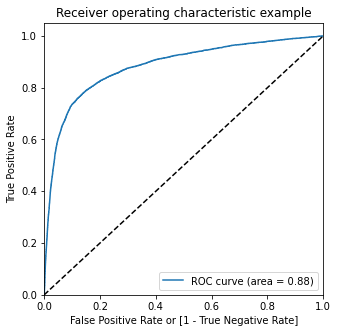

In [211]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

### Selecting cutoff

In [215]:

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      1    0.249862          1    1    1    1    0    0    0    0    0    0   
1      0    0.000529          0    1    0    0    0    0    0    0    0    0   
2      0    0.011948          0    1    0    0    0    0    0    0    0    0   
3      0    0.000018          0    1    0    0    0    0    0    0    0    0   
4      0    0.022006          0    1    0    0    0    0    0    0    0    0   

   0.9  
0    0  
1    0  
2    0  
3    0  
4    0

In [216]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.102502  1.000000  0.000000
0.1   0.1  0.763764  0.849826  0.753935
0.2   0.2  0.873516  0.749477  0.887682
0.3   0.3  0.911106  0.623693  0.943930
0.4   0.4  0.918606  0.425958  0.974870
0.5   0.5  0.910516  0.206794  0.990887
0.6   0.6  0.905141  0.109233  0.996041
0.7   0.7  0.899945  0.039199  0.998249
0.8   0.8  0.898302  0.014460  0.999244
0.9   0.9  0.897998  0.006794  0.999781


In [217]:
num = [0.1]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(sensi)
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

0.8498257839721254
     prob  accuracy     sensi     speci
0.0   0.0  0.102502  1.000000  0.000000
0.1   0.1  0.763764  0.849826  0.753935
0.2   0.2  0.873516  0.749477  0.887682
0.3   0.3  0.911106  0.623693  0.943930
0.4   0.4  0.918606  0.425958  0.974870
0.5   0.5  0.910516  0.206794  0.990887
0.6   0.6  0.905141  0.109233  0.996041
0.7   0.7  0.899945  0.039199  0.998249
0.8   0.8  0.898302  0.014460  0.999244
0.9   0.9  0.897998  0.006794  0.999781


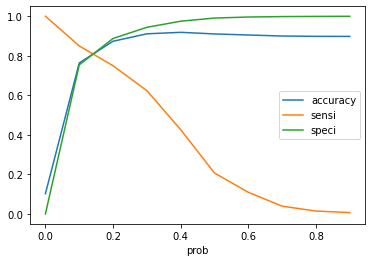

In [218]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [219]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [220]:

print("Precision: ",precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

Precision:  0.2828645984343288


In [221]:
print("Recall: ",recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

Recall:  0.8498257839721254


In [222]:
f1_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.42445072873613227

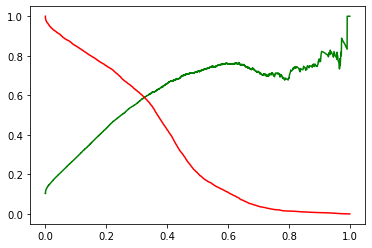

In [223]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Predicting on Test data

In [224]:
X_test_scaled = scaler.transform(X_test[col])
X_test_sm = sm.add_constant(X_test_scaled)

In [225]:
y_test_pred = res.predict(X_test_sm)

In [226]:
y_pred_final = pd.DataFrame({"Churn_Prob":y_test_pred, "Churn":y_test})
y_pred_final

Churn_Prob  Churn
3425     0.447873      1
33067    0.530809      1
52420    0.397181      0
5220     0.088683      0
33958    0.226489      1
...           ...    ...
26667    0.010526      0
23021    0.027416      0
322      0.068530      0
59049    0.025216      0
29193    0.005253      0

[14000 rows x 2 columns]

In [227]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [228]:
y_pred_final.head()

Churn_Prob  Churn  final_predicted
3425     0.447873      1                1
33067    0.530809      1                1
52420    0.397181      0                1
5220     0.088683      0                0
33958    0.226489      1                1

In [229]:
confusion2 = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted )
confusion2

array([[9598, 3010],
       [ 217, 1175]])

In [230]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [231]:
print("Senstivity: ",TP / float(TP+FN))

Senstivity:  0.8441091954022989


In [232]:
print("Specificity: ",TN / float(TN+FP))

Specificity:  0.7612626903553299


In [233]:
print("Test Accuracy:",metrics.accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted))

Test Accuracy: 0.7695


##  PCA

In [243]:
#(X_train,y_train)   (X_test, y_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.76889836,  0.50719031, -0.76961238, ..., -0.463407  ,
         0.09167897,  5.77812281],
       [-0.36554863, -0.28527968, -0.55703867, ...,  0.10823993,
         0.09295409,  0.00665361],
       [ 0.07674707,  0.53849252,  0.36957962, ...,  0.3404715 ,
         0.09359165,  0.00842879],
       ...,
       [-0.32585944, -0.260786  , -0.35513837, ...,  0.96676115,
         0.09295409,  0.01304426],
       [ 0.26764669,  0.08244319,  0.00882053, ...,  0.16813676,
         0.08849117,  0.00878383],
       [ 0.74048469,  1.87069998,  1.64695171, ...,  2.45997858,
         0.08976629,  0.00878383]])

In [244]:
pca = PCA(random_state=42)

In [245]:
pca.fit(X_train_scaled)

PCA(random_state=42)

In [246]:
pca.components_

array([[ 2.22130335e-01,  2.59839953e-01,  2.66534606e-01,
         1.54451119e-01,  2.30364219e-01,  2.35047984e-01,
         2.69471790e-02,  4.41750520e-02,  1.89850525e-01,
         2.78256324e-01,  2.85048428e-01,  2.97610741e-01,
         1.51981318e-01,  1.61571082e-01,  2.32721791e-01,
         2.38574327e-01,  2.52391658e-01,  2.61861496e-01,
         5.83822816e-02,  1.45122090e-01,  1.42388170e-01,
         1.76947138e-01,  1.43963011e-01,  6.07684952e-02,
         2.91224074e-02,  9.19547042e-03],
       [ 2.14314255e-01,  2.60333140e-01,  2.67506656e-01,
         1.63199961e-01,  2.21688189e-01,  2.21437617e-01,
         8.81643229e-02,  1.49302611e-01, -1.53870830e-02,
        -9.48046518e-03, -1.81101966e-02, -1.62191581e-02,
        -3.05308036e-01, -3.04821880e-01, -2.44785677e-01,
        -2.40534307e-01, -3.54314112e-01, -3.48267400e-01,
         4.02978667e-02,  1.94173014e-01,  2.03328008e-01,
         1.04308631e-01,  6.94759618e-02, -1.05440554e-01,
         2.31

In [247]:
pca.explained_variance_ratio_

array([2.59298127e-01, 1.25439745e-01, 7.74254232e-02, 6.98172003e-02,
       6.26803992e-02, 5.11667707e-02, 4.88820236e-02, 4.02701271e-02,
       3.91819959e-02, 3.53035426e-02, 3.31849827e-02, 2.40266617e-02,
       2.29211687e-02, 2.14357968e-02, 1.89979569e-02, 1.43528584e-02,
       1.22861534e-02, 1.11203611e-02, 8.95682426e-03, 7.05553492e-03,
       6.71778887e-03, 4.92865937e-03, 3.47960111e-03, 9.10634079e-04,
       1.08926074e-04, 5.07371547e-05])

In [248]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

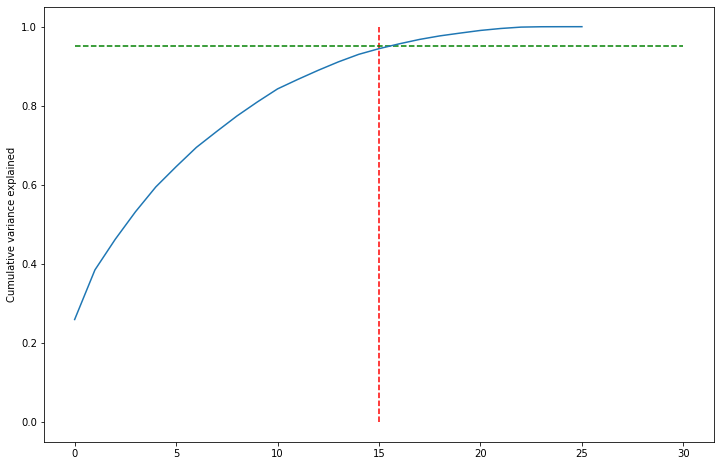

In [249]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [250]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 25.93,  38.47,  46.21,  53.19,  59.46,  64.58,  69.47,  73.5 ,
        77.42,  80.95,  84.27,  86.67,  88.96,  91.1 ,  93.  ,  94.44,
        95.67,  96.78,  97.68,  98.39,  99.06,  99.55,  99.9 ,  99.99,
       100.  , 100.01])

In [254]:
pca_final = IncrementalPCA(n_components=15)
X_train_scaled.shape

(55999, 26)

In [255]:
df_train_pca = pca_final.fit_transform(X_train_scaled)
df_test_pca = pca_final.transform(X_test_scaled)

In [256]:
corrmat = np.corrcoef(df_train_pca.transpose())

<AxesSubplot:>

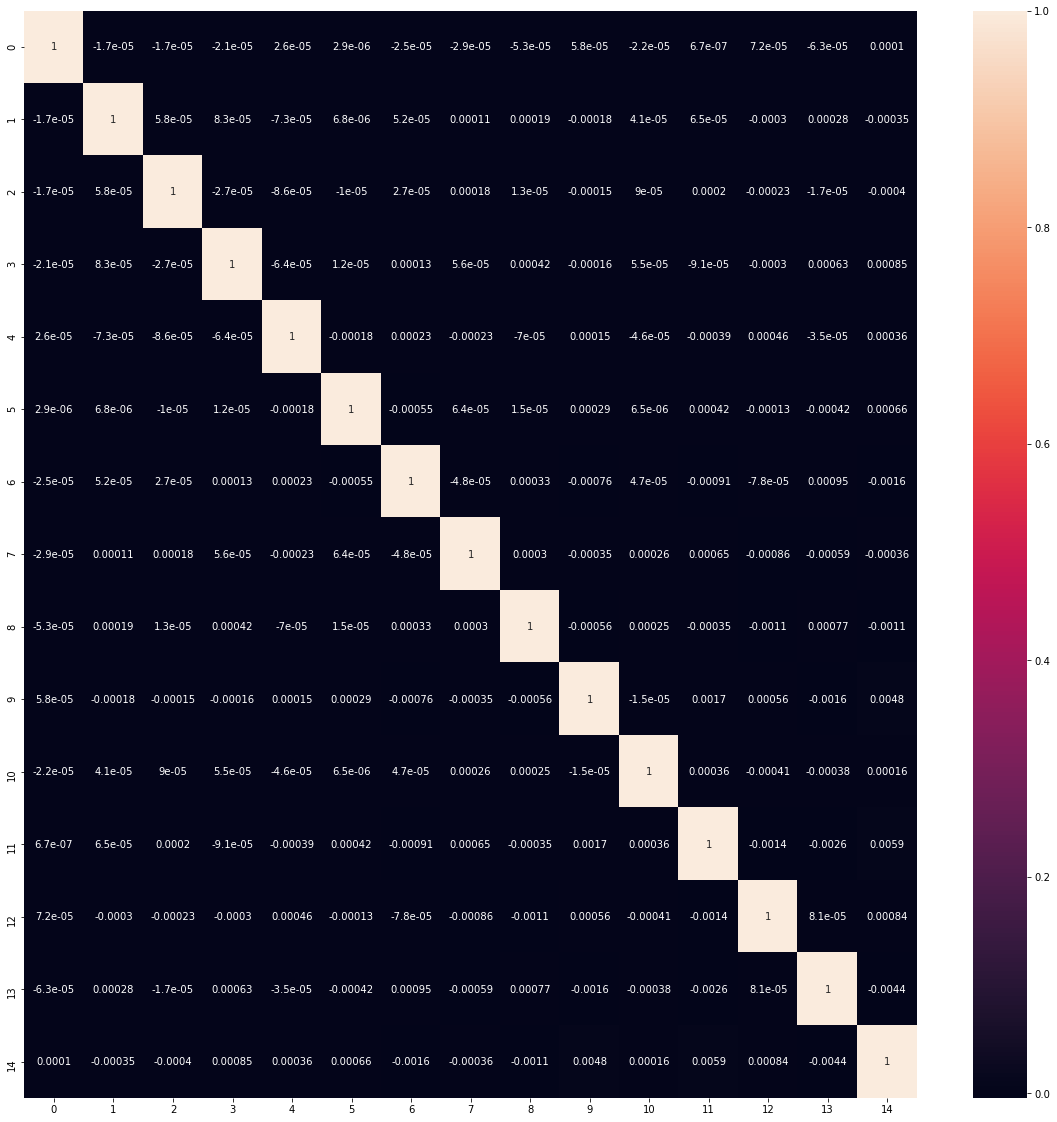

In [260]:
plt.figure(figsize=[20,20])
sns.heatmap(corrmat, annot=True)

In [261]:
X_test_scaled = scaler.transform(X_test)
df_test_pca = pca_final.transform(X_test_scaled)
df_test_pca.shape

(14000, 15)

## GBM Model

In [262]:
gb = GradientBoostingClassifier(random_state=100)
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 100,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [263]:
gb.fit(df_train_pca, y_train)
gb_predictions = gb.predict(df_test_pca)

In [264]:
accuracy_score(y_test, gb_predictions)

0.9276428571428571

In [265]:
gb_predictions = gb.predict(df_train_pca)
accuracy_score(y_train, gb_predictions)

0.9289630171967357

In [266]:
gb_predictions = gb.predict(df_test_pca)

In [267]:
recall_score(y_test,gb_predictions)

0.4827586206896552

## AdaBoost

In [268]:
adaboost =  AdaBoostClassifier(n_estimators=200, random_state=1)

In [269]:
adaboost.fit(df_train_pca, y_train)

AdaBoostClassifier(n_estimators=200, random_state=1)

In [270]:
y_pred = adaboost.predict(df_train_pca)

In [271]:
print('Accuracy of the model is:  ',accuracy_score(y_train, y_pred))

Accuracy of the model is:   0.9231414846693691


In [272]:
y_pred = adaboost.predict(df_test_pca)
print('Accuracy of the model is:  ',accuracy_score(y_test, y_pred))

Accuracy of the model is:   0.9223571428571429


In [273]:
recall_score(y_test,y_pred)

0.46264367816091956

## Logistic Regression on PCA

In [274]:
X_train_sm = sm.add_constant(df_train_pca)
X_train_sm

array([[ 1.00000000e+00, -1.85630541e+00,  6.92000462e-02, ...,
         2.64702243e+00,  2.19383864e-02, -4.71259028e-01],
       [ 1.00000000e+00,  1.70698324e+00,  2.22559438e+00, ...,
         1.54270197e-01,  8.22127088e-01,  1.71195616e-01],
       [ 1.00000000e+00,  1.03793225e-03, -4.58213103e-01, ...,
        -6.40542733e-01,  4.88012110e-01,  5.65519642e-02],
       ...,
       [ 1.00000000e+00, -7.32759250e-01,  3.59987728e-01, ...,
        -2.17807894e-01,  5.63901001e-01, -2.46556123e-01],
       [ 1.00000000e+00, -8.05289114e-01, -7.08622290e-01, ...,
        -4.94813785e-01,  3.90802520e-01,  1.86374917e-01],
       [ 1.00000000e+00,  6.04135389e+00,  2.06987345e-01, ...,
        -3.26383173e-01,  6.72415379e-01, -3.86901437e-01]])

In [275]:
y_train = pd.DataFrame(y_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()

X_test_sm = sm.add_constant(df_test_pca)

In [276]:
y_test_pred = res.predict(X_test_sm)

In [277]:
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [278]:
print("Test Accuracy:",metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted))

Test Accuracy: 0.7663571428571428


In [279]:
recall_score(y_test_pred_final.Churn, y_test_pred_final.predicted)

0.8247126436781609

## SVM

In [280]:
from sklearn import svm
from sklearn import metrics

In [281]:
svm_model = svm.SVC(kernel='rbf')
# fit  linear rbf
svm_model.fit(df_train_pca, y_train)

SVC()

In [282]:
predictions = svm_model.predict(df_test_pca)

print(metrics.accuracy_score(y_true=y_test, y_pred=predictions))

0.9162142857142858


In [283]:
recall_score(y_true=y_test, y_pred=predictions)

0.2377873563218391

In [284]:
predictions = svm_model.predict(df_train_pca)
 
print(metrics.accuracy_score(y_true=y_train, y_pred=predictions))

0.9139984642582903


## XGBoost

In [285]:
xgb_cfl = xgb.XGBClassifier(n_jobs = 12,objective = 'binary:logistic')
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [286]:
xgb_cfl.fit(df_train_pca, y_train)  

xgb_predictions = xgb_cfl.predict(df_test_pca)


[21:39:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [287]:
xgb_predictions = xgb_cfl.predict(df_test_pca)

In [288]:
print(metrics.accuracy_score(y_true=y_test, y_pred=xgb_predictions))

0.9271428571428572


In [289]:
recall_score(y_true =y_test, y_pred=xgb_predictions)

0.5043103448275862

## Random Forest

In [290]:
rf = RandomForestClassifier(random_state=42, n_jobs=12)

In [291]:
params = {
    'max_depth': [40,50,60],
    'min_samples_split':[5],
    'min_samples_leaf': [3],
    'n_estimators': [95,100,110]
}

In [293]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(feature_df,y)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=12, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [40, 50, 60], 'min_samples_leaf': [3],
                         'min_samples_split': [5],
                         'n_estimators': [95, 100, 110]},
             scoring='accuracy', verbose=1)

In [294]:
grid_search.best_score_


0.9419563273003355

In [295]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=95, n_jobs=12, random_state=42)

In [297]:
rf = RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=95, n_jobs=12, random_state=42,oob_score = True)

In [298]:
rf.fit(feature_df,y)


RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=95, n_jobs=12, oob_score=True,
                       random_state=42)

In [299]:
rf.oob_score_

0.941699167130959

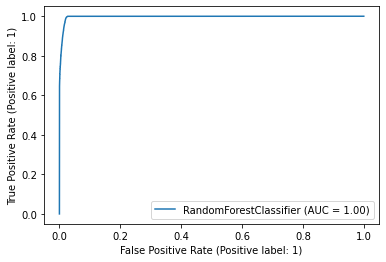

In [301]:
plot_roc_curve(rf, feature_df,y)
plt.show()

In [302]:
pred = rf.predict(feature_df)

In [303]:
print(metrics.accuracy_score(y_true=y, y_pred=pred))

0.9745710653009328


In [304]:
print("Precision: ",precision_score(y, pred))

Precision:  0.9535593220338983


In [305]:
print("Recall: ",recall_score(y, pred))

Recall:  0.7888390353337073


## Kaggle

In [306]:
kg_test = pd.read_csv("test (1).csv")
kg_test["date_of_last_rech_8"] = pd.to_datetime(kg_test['date_of_last_rech_8'])
kg_test["date_of_last_rech_7"] = pd.to_datetime(kg_test['date_of_last_rech_7'])
kg_test["date_of_last_rech_6"] = pd.to_datetime(kg_test['date_of_last_rech_6'])

kg_test['rchrge2_days']=(kg_test['date_of_last_rech_8'] - kg_test['date_of_last_rech_7']).dt.days
kg_test['rchrge1_days']=(kg_test['date_of_last_rech_7'] - kg_test['date_of_last_rech_6']).dt.days

kg_test = kg_test.fillna(0)
kg_test = pd.DataFrame(kg_test)
id_kg = kg_test['id']

In [307]:
kg_test = kg_test[feature_df.columns]

In [308]:
pred = rf.predict(kg_test)

In [309]:
result = pd.DataFrame({"id":id_kg,"churn_probability":pred})
result.to_csv('kaggleRF.csv', header=True,index=False)

## Model Selection

### Selection Metric: Senstivity, that is number of churn correctly predicted out of total number of churns
### Model: Logistic Regression, with Feature Selection using RFE and Random Forest
### Reasons: 
### 1. Offers senstivity of 85% on train and 84% on test data.
### 2. Most impactful features are easy to interpret.